# Report 1. Model Performance and Results

In this `ipynb` file we work through a predicting model for the GDP growth for countries around the world. The `DataFrame` is given in `SQLite3` format, which is a similar version from the [Kaggle](https://www.kaggle.com/fernandol/countries-of-the-world) but has been modified for educational purposes. All the necessary packages are in the `requirements.txt` file.

This report is organized in the 3 sections listed below.

1. Importing data and cleaning
    - 1a Importing data
    - 1b Data cleaning
2. Training
    - 2a Preparing data for training
    - 2b Model
    - 2c Feature selection for the model
3. Results
4. Conclusions

In [59]:
import sys, os; sys.path.insert(0, os.path.dirname(os.getcwd()))
import sqlite3
import pandas as pd
import utils.io
import utils.preprocessing
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import sklearn.linear_model
import xgboost
import shap
from utils import config
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from mlxtend.feature_selection import SequentialFeatureSelector

# Environment settings:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_column', None)

### 1. Importing data and cleaning
#### 1a Importing data

As we said before, the given database is given in `SQLite3` format and has to be imported to our program.

In [3]:
tables = {}
with sqlite3.connect(config.DATABASE_PATH) as conn: # Looking for the SQLite3 file
    cursor = conn.cursor() # Establishing connection with the database
    cursor.execute( "SELECT name FROM sqlite_master WHERE type='table';" ) # Creating cursor table
    table_names = cursor.fetchall() # Returns all lists form the database
    cursor.close() # Closes database connection
    for table_name in table_names: # Formats tables as we desire
        table_name = table_name[0]
        tables[table_name] = pd.read_sql_query(f"SELECT * from {table_name}", conn)

print('Tables found are:')
print(list( tables.keys()))

# Load tables into the namespace
locals().update(tables)

Tables found are:
['Countries', 'CountryNotes', 'Footnotes', 'CountryIndicators', 'Indicators', 'IndicatorsNotes', 'EstimatedGPDGrowth']


We can print parts of the tables we just read so we can check whether we keep them or not.

In [4]:
for table_name, table in tables.items():
    print(f'------------------------ {table_name} ------------------------')
    table

------------------------ Countries ------------------------


,CountryCode,ShortName,TableName,LongName,Alpha2Code,CurrencyUnit,SpecialNotes,Region,IncomeGroup,Wb2Code,NationalAccountsBaseYear,NationalAccountsReferenceYear,SnaPriceValuation,LendingCategory,OtherGroups,SystemOfNationalAccounts,AlternativeConversionFactor,PppSurveyYear,BalanceOfPaymentsManualInUse,ExternalDebtReportingStatus,SystemOfTrade,GovernmentAccountingConcept,ImfDataDisseminationStandard,LatestPopulationCensus,LatestHouseholdSurvey,SourceOfMostRecentIncomeAndExpenditureData,VitalRegistrationComplete,LatestAgriculturalCensus,LatestIndustrialData,LatestTradeData,LatestWaterWithdrawalData
0,AFG,Afghanistan,Afghanistan,Islamic State of Afghanistan,AF,Afghan afghani,Fiscal year end: March 20; reporting period fo...,South Asia,Low income,AF,2002/03,,Value added at basic prices (VAB),IDA,HIPC,Country uses the 1993 System of National Accou...,,,,Actual,General trade system,Consolidated central government,General Data Dissemination System (GDDS),1979,"Multiple Indicator Cluster Survey (MICS), 2010/11","Integrated household survey (IHS), 2008",,2013/14,,2013,2000
1,ALB,Albania,Albania,Republic of Albania,AL,Albanian lek,,Europe & Central Asia,Upper middle income,AL,Original chained constant price data are resca...,1996,Value added at basic prices (VAB),IBRD,,Country uses the 1993 System of National Accou...,,Rolling,"IMF Balance of Payments Manual, 6th edition.",Actual,General trade system,Budgetary central government,General Data Dissemination System (GDDS),2011,"Demographic and Health Survey (DHS), 2008/09",Living Standards Measurement Study Survey (LSM...,Yes,2012,2011,2013,2006
2,DZA,Algeria,Algeria,People's Democratic Republic of Algeria,DZ,Algerian dinar,,Middle East & North Africa,Upper middle income,DZ,1980,,Value added at basic prices (VAB),IBRD,,Country uses the 1968 System of National Accou...,,2011,"IMF Balance of Payments Manual, 6th edition.",Actual,Special trade system,Budgetary central government,General Data Dissemination System (GDDS),2008,"Multiple Indicator Cluster Survey (MICS), 2012","Integrated household survey (IHS), 1995",,,2010,2013,2001
3,ASM,American Samoa,American Samoa,American Samoa,AS,U.S. dollar,,East Asia & Pacific,Upper middle income,AS,,,,,,Country uses the 1968 System of National Accou...,,2011 (household consumption only).,,,Special trade system,,,2010,,,Yes,2007,,,
4,ADO,Andorra,Andorra,Principality of Andorra,AD,Euro,,Europe & Central Asia,High income: nonOECD,AD,2000,,Value added at basic prices (VAB),,,Country uses the 1968 System of National Accou...,,,,,Special trade system,,,2011. Population data compiled from administra...,,,Yes,,,2006,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,WBG,West Bank and Gaza,West Bank and Gaza,West Bank and Gaza,PS,Israeli new shekel,The new base year is 2004.,Middle East & North Africa,Lower middle income,GZ,2004,,Value added at basic prices (VAB),,,Country uses the 1968 System of National Accou...,,2011,"IMF Balance of Payments Manual, 6th edition.",,Special trade system,Budgetary central government,Special Data Dissemination Standard (SDDS),2007,"Multiple Indicator Cluster Survey (MICS), 2014","Integrated household survey (IHS), 2011",,,2010,,2005
243,WLD,World,World,World,1W,,World aggregate.,,,1W,,,,,,,,,,,,,,,,,,,,,
244,YEM,Yemen,"Yemen, Rep.",Republic of Yemen,YE,Yemeni rial,Based on official government statistics and In...,Middle East & North Africa,Lower middle income,RY,2007,,Value added at producer prices (VAP),IDA,,Country uses the 1993 System of National Accou...,199096,2011,"IMF Balance of Payments Manual, 6th edition.",Estimate,Special trade system,Budgetary central government,General Data Dissemination System (GDDS),2004,"Demographic and Health Survey (DHS), 2013","Expenditure survey/budget survey (ES/BS), 2005",,,2009,2013,2005
245,ZMB,Zambia,Zambia,Republic of Zambia,ZM,New Zambian kwacha,The new base year is 2010. National accounts d...,Sub-Sahara

------------------------ CountryNotes ------------------------


,CountryCode,IndicatorCode,Description
0,ABW,EG.EGY.PRIM.PP.KD,Sources: Estimated based on UN Energy Statisti...
1,ABW,EG.ELC.RNEW.ZS,Sources: UN Energy Statistics (2014)
2,ABW,EG.FEC.RNEW.ZS,Sources: UN Energy Statistics (2014)
3,ABW,SM.POP.NETM,Data sources : United Nations World Population...
4,ABW,SM.POP.TOTL,Estimates are derived from data on foreign-bor...
...,...,...,...
4852,ZWE,SP.DYN.LE00.IN,Derived using male and female life expectancy
4853,ZWE,SP.DYN.LE00.MA.IN,Data sources : United Nations World Population...
4854,ZWE,SP.DYN.TFRT.IN,Data sources : United Nations World Population...
4855,ZWE,SP.POP.GROW,Data sources: United Nations World Population ...


------------------------ Footnotes ------------------------


,CountryCode,IndicatorCode,Year,Description
0,ABW,AG.LND.FRST.K2,YR1990,Not specified
1,ABW,AG.LND.FRST.K2,YR2000,Not specified
2,ABW,AG.LND.FRST.K2,YR2005,Not specified
3,ABW,BX.KLT.DINV.CD.WD,YR1987,Source: United Nations Conference on Trade and...
4,ABW,BX.KLT.DINV.CD.WD,YR1988,Source: United Nations Conference on Trade and...
...,...,...,...,...
462320,ZWE,TX.VAL.MRCH.XD.WD,YR2006,Source: UNCTAD Handbook of Statistics and data...
462321,ZWE,TX.VAL.MRCH.XD.WD,YR2007,Source: UNCTAD Handbook of Statistics and data...
462322,ZWE,TX.VAL.MRCH.XD.WD,YR2008,Source: UNCTAD Handbook of Statistics and data...
462323,ZWE,TX.VAL.MRCH.XD.WD,YR2009,Source: UNCTAD Handbook of Statistics and data...


------------------------ CountryIndicators ------------------------


,CountryCode,IndicatorCode,Year,Value
0,ARB,SP.ADO.TFRT,1960,1.335609e+02
1,ARB,SP.POP.DPND,1960,8.779760e+01
2,ARB,SP.POP.DPND.OL,1960,6.634579e+00
3,ARB,SP.POP.DPND.YG,1960,8.102333e+01
4,ARB,MS.MIL.XPRT.KD,1960,3.000000e+06
...,...,...,...,...
5026216,ZWE,SP.URB.TOTL.IN.ZS,2010,3.319600e+01
5026217,ZWE,SP.URB.GROW,2010,1.279630e+00
5026218,ZWE,DT.DOD.DIMF.CD,2010,5.287290e+08
5026219,ZWE,SN.ITK.VITA.ZS,2010,4.930002e+01


------------------------ Indicators ------------------------


,IndicatorCode,Topic,IndicatorName,ShortDefinition,LongDefinition,UnitOfMeasure,Periodicity,BasePeriod,OtherNotes,AggregationMethod,LimitationsAndExceptions,NotesFromOriginalSource,GeneralComments,Source,StatisticalConceptAndMethodology,DevelopmentRelevance,RelatedSourceLinks,OtherWebLinks,RelatedIndicators,LicenseType
0,BN.KLT.DINV.CD,Economic Policy & Debt: Balance of payments: C...,"Foreign direct investment, net (BoP, current US$)",,Foreign direct investment are the net inflows ...,,Annual,,,,,,Note: Data are based on the sixth edition of t...,"International Monetary Fund, Balance of Paymen...",,,,,,Open
1,BX.KLT.DINV.WD.GD.ZS,Economic Policy & Debt: Balance of payments: C...,"Foreign direct investment, net inflows (% of GDP)",,Foreign direct investment are the net inflows ...,,Annual,,,Weighted average,FDI data do not give a complete picture of int...,,Note: Data starting from 2005 are based on the...,"International Monetary Fund, International Fin...",Data on equity flows are based on balance of p...,Private financial flows - equity and debt - ac...,,,,Open
2,BX.KLT.DINV.CD.WD,Economic Policy & Debt: Balance of payments: C...,"Foreign direct investment, net inflows (BoP, c...",,Foreign direct investment refers to direct inv...,,Annual,,,Sum,FDI data do not give a complete picture of int...,,Note: Data starting from 2005 are based on the...,"International Monetary Fund, Balance of Paymen...",Data on equity flows are based on balance of p...,Private financial flows - equity and debt - ac...,,,,Open
3,BM.KLT.DINV.GD.ZS,Economic Policy & Debt: Balance of payments: C...,"Foreign direct investment, net outflows (% of ...",,Foreign direct investment are the net inflows ...,,Annual,,,Weighted average,,,Note: Data are based on the sixth edition of t...,"International Monetary Fund, International Fin...",,,,,,Open
4,BN.TRF.KOGT.CD,Economic Policy & Debt: Balance of payments: C...,"Net capital account (BoP, current US$)",,Net capital account records acquisitions and d...,,Annual,,,,,,Note: Data are based on the sixth edition of t...,"International Monetary Fund, Balance of Paymen...",,,,,,Open
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1340,SL.UEM.1524.FE.NE.ZS,Social Protection & Labor: Unemployment,"Unemployment, youth female (% of female labor ...",,Youth unemployment refers to the share of the ...,,Annual,,,Weighted average,Data on youth unemployment are drawn from labo...,,"Data are based on labor force sample surveys, ...","International Labour Organization, Key Indicat...",The standard definition of unemployed persons ...,Youth unemployment is an important policy issu...,,,,Open
1341,SL.UEM.1524.MA.ZS,Social Protection & Labor: Unemployment,"Unemployment, youth male (% of male labor forc...",,Youth unemployment refers to the share of the ...,,Annual,,,Weighted average,There may be persons not currently in the labo...,,The unemployment rates presented here are the ...,"International Labour Organization, Key Indicat...",The standard definition of unemployed persons ...,Youth unemployment is an important policy issu...,,,,Open
1342,SL.UEM.1524.MA.NE.ZS,Social Protection & Labor: Unemployment,"Unemployment, youth male (% of male labor forc...",,Youth unemployment refers to the share of the ...,,Annual,,,Weighted average,Data on youth unemployment are drawn from labo...,,"Data are based on labor force sample surveys, ...","International Labour Organization, Key Indicat...",The standard definition of unemployed persons ...,Youth unemployment is an important policy issu...,,,,Open
1343,SL.UEM.1524.ZS,Social Protection & Labor: Unemployment,"Unemployment, youth total (% of total labor fo...",,Youth unemployment refers to the share of the ...,,Annual,,,Weighted average,There may be persons not currently in the labo...,,The unemployment rates presented here are the ...,"International Labour Organization, Key Indicat...",The standard definition of unemployed persons ...,Youth unemployment is an 

------------------------ IndicatorsNotes ------------------------


,IndicatorCode,Year,Description
0,SP.ADO.TFRT,YR1960,Interpolated using data for 1957 and 1962.
1,SP.DYN.AMRT.FE,YR1960,"Interpolated using data for 1957 and 1962, if ..."
2,SP.DYN.AMRT.MA,YR1960,"Interpolated using data for 1957 and 1962, if ..."
3,SP.DYN.TO65.FE.ZS,YR1960,Interpolated using data for 1957 and 1962.
4,SP.DYN.TO65.MA.ZS,YR1960,Interpolated using data for 1957 and 1962.
...,...,...,...
338,SP.ADO.TFRT,YR2010,Interpolated using data for 2007 and 2012.
339,SP.DYN.AMRT.FE,YR2010,"Interpolated using data for 2007 and 2012, if ..."
340,SP.DYN.AMRT.MA,YR2010,"Interpolated using data for 2007 and 2012, if ..."
341,SP.DYN.TO65.FE.ZS,YR2010,Interpolated using data for 2007 and 2012.


------------------------ EstimatedGPDGrowth ------------------------


,CountryCode,Year,Value
0,ABW,2011,3.779963
1,ADO,2011,2.413952
2,AFG,2011,11.016120
3,AGO,2011,5.735547
4,ALB,2011,4.915038
...,...,...,...
242,YEM,2011,5.313151
243,ZAF,2011,4.932665
244,ZAR,2011,8.584383
245,ZMB,2011,9.854950


The most important tables of data we will need for making the predictions are:

1. CountryIndicators
2. Countries
3. Indicators

The first one in the list is the most important because gives us the country indicators per year. Out of curiosity, we can look for the meaning of each indicator in [The World Bank Database](https://data.worldbank.org/indicator).

Working a bit with the table `'CountryIndicators'`

In [5]:
country_indicators = tables['CountryIndicators']

In [6]:
country_indicators

,CountryCode,IndicatorCode,Year,Value
0,ARB,SP.ADO.TFRT,1960,1.335609e+02
1,ARB,SP.POP.DPND,1960,8.779760e+01
2,ARB,SP.POP.DPND.OL,1960,6.634579e+00
3,ARB,SP.POP.DPND.YG,1960,8.102333e+01
4,ARB,MS.MIL.XPRT.KD,1960,3.000000e+06
...,...,...,...,...
5026216,ZWE,SP.URB.TOTL.IN.ZS,2010,3.319600e+01
5026217,ZWE,SP.URB.GROW,2010,1.279630e+00
5026218,ZWE,DT.DOD.DIMF.CD,2010,5.287290e+08
5026219,ZWE,SN.ITK.VITA.ZS,2010,4.930002e+01


In [7]:
df = pd.pivot(country_indicators, index=['CountryCode', 'Year'], columns=['IndicatorCode'], values='Value').reset_index()

So here we encounter a problem. As we see in the table below, there is a considerable amount of `NaN` variables for the indicators. We need to remedy this by removing indicators with too many Nans for non relevance or to modify some indicators for matching values similar to each countries' group.

In [8]:
df

IndicatorCode CountryCode  Year  AG.AGR.TRAC.NO  AG.CON.FERT.PT.ZS  \
0                     ABW  1960             NaN                NaN   
1                     ABW  1961             NaN                NaN   
2                     ABW  1962             NaN                NaN   
3                     ABW  1963             NaN                NaN   
4                     ABW  1964             NaN                NaN   
...                   ...   ...             ...                ...   
12592                 ZWE  2006             NaN         210.442742   
12593                 ZWE  2007             NaN         171.109177   
12594                 ZWE  2008             NaN         147.903481   
12595                 ZWE  2009             NaN         186.693038   
12596                 ZWE  2010             NaN         215.715190   

IndicatorCode  AG.CON.FERT.ZS  AG.LND.AGRI.K2  AG.LND.AGRI.ZS  AG.LND.ARBL.HA  \
0                         NaN             NaN             NaN             NaN   
1                         NaN            20.0       11.111111          2000.0   
2                         NaN            20.0       11.111111          2000.0   
3                         NaN            20.0       11.111111          2000.0   
4                         NaN            20.0       11.111111          2000.0   
...                       ...             ...             ...             ...   
12592               32.356341        163000.0       42.135195       4100000.0   
12593               27.035250        162000.0       41.876696       4000000.0   
12594               21.994118        164500.0       42.522942       4250000.0   
12595               28.778049        163000.0       42.135195       4100000.0   
12596               34.083000        162000.0       41.876696       4000000.0   

IndicatorCode  AG.LND.ARBL.HA.PC  AG.LND.ARBL.ZS  AG.LND.CREL.HA  \
0                            NaN             NaN             NaN   
1                       0.036078       11.111111             NaN   
2                       0.035571       11.111111             NaN   
3                       0.035275       11.111111             NaN   
4                       0.035070       11.111111             NaN   
...                          ...             ...             ...   
12592                   0.312311       10.598423       2289312.0   
12593                   0.300802       10.339925       1949453.0   
12594                   0.314921       10.986170       2235440.0   
12595                   0.298812       10.598423       2080405.0   
12596                   0.286248       10.339925       1891766.0   

IndicatorCode  AG.LND.CROP.ZS  AG.LND.EL5M.ZS  AG.LND.FRST.K2  AG.LND.FRST.ZS  \
0                         NaN             NaN             NaN             NaN   
1                         NaN             NaN             NaN             NaN   
2                         NaN             NaN             NaN             NaN   
3                         NaN             NaN             NaN             NaN   
4                         NaN             NaN             NaN             NaN   
...                       ...             ...             ...             ...   
12592                0.258498             NaN        169320.0       43.768903   
12593                0.258498             NaN        166050.0       42.923614   
12594                0.258498             NaN        162780.0       42.078325   
12595                0.258498             NaN        159510.0       41.233036   
12596                0.258498             NaN        156240.0       40.387747   

IndicatorCode  AG.LND.IRIG.AG.ZS  AG.LND.PRCP.MM  AG.LND.TOTL.K2  \
0                            NaN             NaN             NaN   
1                            NaN             NaN           180.0   
2                            NaN             NaN           180.0   
3                            NaN             NaN           180.0   
4                            NaN             NaN        

#### 1b Data cleaning

As we said before, there are a lot of `NaNs` in the database. It is needed to clean the data, either by discarding samples with too many `NaNs` or removing maybe some indicators.

In [9]:
data = tables['CountryIndicators']
data = pd.pivot(data, index = ['CountryCode', 'Year'], columns = ['IndicatorCode'], values = 'Value').reset_index()
data_countries = tables['Countries']

In [10]:
data

IndicatorCode CountryCode  Year  AG.AGR.TRAC.NO  AG.CON.FERT.PT.ZS  \
0                     ABW  1960             NaN                NaN   
1                     ABW  1961             NaN                NaN   
2                     ABW  1962             NaN                NaN   
3                     ABW  1963             NaN                NaN   
4                     ABW  1964             NaN                NaN   
...                   ...   ...             ...                ...   
12592                 ZWE  2006             NaN         210.442742   
12593                 ZWE  2007             NaN         171.109177   
12594                 ZWE  2008             NaN         147.903481   
12595                 ZWE  2009             NaN         186.693038   
12596                 ZWE  2010             NaN         215.715190   

IndicatorCode  AG.CON.FERT.ZS  AG.LND.AGRI.K2  AG.LND.AGRI.ZS  AG.LND.ARBL.HA  \
0                         NaN             NaN             NaN             NaN   
1                         NaN            20.0       11.111111          2000.0   
2                         NaN            20.0       11.111111          2000.0   
3                         NaN            20.0       11.111111          2000.0   
4                         NaN            20.0       11.111111          2000.0   
...                       ...             ...             ...             ...   
12592               32.356341        163000.0       42.135195       4100000.0   
12593               27.035250        162000.0       41.876696       4000000.0   
12594               21.994118        164500.0       42.522942       4250000.0   
12595               28.778049        163000.0       42.135195       4100000.0   
12596               34.083000        162000.0       41.876696       4000000.0   

IndicatorCode  AG.LND.ARBL.HA.PC  AG.LND.ARBL.ZS  AG.LND.CREL.HA  \
0                            NaN             NaN             NaN   
1                       0.036078       11.111111             NaN   
2                       0.035571       11.111111             NaN   
3                       0.035275       11.111111             NaN   
4                       0.035070       11.111111             NaN   
...                          ...             ...             ...   
12592                   0.312311       10.598423       2289312.0   
12593                   0.300802       10.339925       1949453.0   
12594                   0.314921       10.986170       2235440.0   
12595                   0.298812       10.598423       2080405.0   
12596                   0.286248       10.339925       1891766.0   

IndicatorCode  AG.LND.CROP.ZS  AG.LND.EL5M.ZS  AG.LND.FRST.K2  AG.LND.FRST.ZS  \
0                         NaN             NaN             NaN             NaN   
1                         NaN             NaN             NaN             NaN   
2                         NaN             NaN             NaN             NaN   
3                         NaN             NaN             NaN             NaN   
4                         NaN             NaN             NaN             NaN   
...                       ...             ...             ...             ...   
12592                0.258498             NaN        169320.0       43.768903   
12593                0.258498             NaN        166050.0       42.923614   
12594                0.258498             NaN        162780.0       42.078325   
12595                0.258498             NaN        159510.0       41.233036   
12596                0.258498             NaN        156240.0       40.387747   

IndicatorCode  AG.LND.IRIG.AG.ZS  AG.LND.PRCP.MM  AG.LND.TOTL.K2  \
0                            NaN             NaN             NaN   
1                            NaN             NaN           180.0   
2                            NaN             NaN           180.0   
3                            NaN             NaN           180.0   
4                            NaN             NaN        

In [11]:
data_countries

,CountryCode,ShortName,TableName,LongName,Alpha2Code,CurrencyUnit,SpecialNotes,Region,IncomeGroup,Wb2Code,NationalAccountsBaseYear,NationalAccountsReferenceYear,SnaPriceValuation,LendingCategory,OtherGroups,SystemOfNationalAccounts,AlternativeConversionFactor,PppSurveyYear,BalanceOfPaymentsManualInUse,ExternalDebtReportingStatus,SystemOfTrade,GovernmentAccountingConcept,ImfDataDisseminationStandard,LatestPopulationCensus,LatestHouseholdSurvey,SourceOfMostRecentIncomeAndExpenditureData,VitalRegistrationComplete,LatestAgriculturalCensus,LatestIndustrialData,LatestTradeData,LatestWaterWithdrawalData
0,AFG,Afghanistan,Afghanistan,Islamic State of Afghanistan,AF,Afghan afghani,Fiscal year end: March 20; reporting period fo...,South Asia,Low income,AF,2002/03,,Value added at basic prices (VAB),IDA,HIPC,Country uses the 1993 System of National Accou...,,,,Actual,General trade system,Consolidated central government,General Data Dissemination System (GDDS),1979,"Multiple Indicator Cluster Survey (MICS), 2010/11","Integrated household survey (IHS), 2008",,2013/14,,2013,2000
1,ALB,Albania,Albania,Republic of Albania,AL,Albanian lek,,Europe & Central Asia,Upper middle income,AL,Original chained constant price data are resca...,1996,Value added at basic prices (VAB),IBRD,,Country uses the 1993 System of National Accou...,,Rolling,"IMF Balance of Payments Manual, 6th edition.",Actual,General trade system,Budgetary central government,General Data Dissemination System (GDDS),2011,"Demographic and Health Survey (DHS), 2008/09",Living Standards Measurement Study Survey (LSM...,Yes,2012,2011,2013,2006
2,DZA,Algeria,Algeria,People's Democratic Republic of Algeria,DZ,Algerian dinar,,Middle East & North Africa,Upper middle income,DZ,1980,,Value added at basic prices (VAB),IBRD,,Country uses the 1968 System of National Accou...,,2011,"IMF Balance of Payments Manual, 6th edition.",Actual,Special trade system,Budgetary central government,General Data Dissemination System (GDDS),2008,"Multiple Indicator Cluster Survey (MICS), 2012","Integrated household survey (IHS), 1995",,,2010,2013,2001
3,ASM,American Samoa,American Samoa,American Samoa,AS,U.S. dollar,,East Asia & Pacific,Upper middle income,AS,,,,,,Country uses the 1968 System of National Accou...,,2011 (household consumption only).,,,Special trade system,,,2010,,,Yes,2007,,,
4,ADO,Andorra,Andorra,Principality of Andorra,AD,Euro,,Europe & Central Asia,High income: nonOECD,AD,2000,,Value added at basic prices (VAB),,,Country uses the 1968 System of National Accou...,,,,,Special trade system,,,2011. Population data compiled from administra...,,,Yes,,,2006,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,WBG,West Bank and Gaza,West Bank and Gaza,West Bank and Gaza,PS,Israeli new shekel,The new base year is 2004.,Middle East & North Africa,Lower middle income,GZ,2004,,Value added at basic prices (VAB),,,Country uses the 1968 System of National Accou...,,2011,"IMF Balance of Payments Manual, 6th edition.",,Special trade system,Budgetary central government,Special Data Dissemination Standard (SDDS),2007,"Multiple Indicator Cluster Survey (MICS), 2014","Integrated household survey (IHS), 2011",,,2010,,2005
243,WLD,World,World,World,1W,,World aggregate.,,,1W,,,,,,,,,,,,,,,,,,,,,
244,YEM,Yemen,"Yemen, Rep.",Republic of Yemen,YE,Yemeni rial,Based on official government statistics and In...,Middle East & North Africa,Lower middle income,RY,2007,,Value added at producer prices (VAP),IDA,,Country uses the 1993 System of National Accou...,199096,2011,"IMF Balance of Payments Manual, 6th edition.",Estimate,Special trade system,Budgetary central government,General Data Dissemination System (GDDS),2004,"Demographic and Health Survey (DHS), 2013","Expenditure survey/budget survey (ES/BS), 2005",,,2009,2013,2005
245,ZMB,Zambia,Zambia,Republic of Zambia,ZM,New Zambian kwacha,The new base year is 2010. National accounts d...,Sub-Sahara

We check the proportion of NaN variables across the years

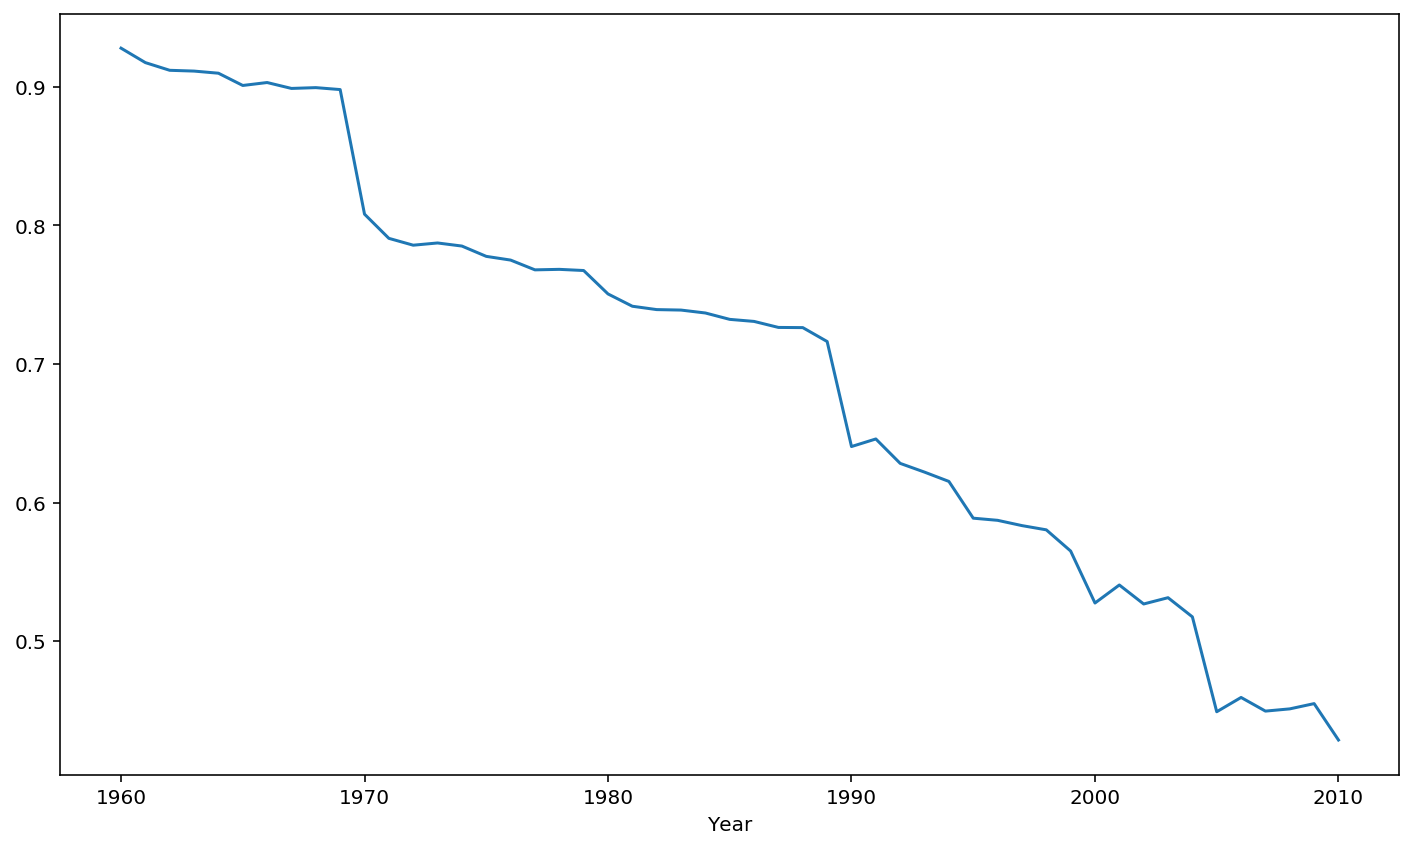

In [12]:
data.isnull().mean(axis = 1).groupby(data['Year']).mean().plot()

We discard the indicators that have more than 30% of NaN values, counting from 1990.

In [13]:
def clean_data_cols_nan(data, percentage_min_not_nans, from_year):
    data = data.loc[:, data[data['Year'] >= from_year].isnull().mean() < (1 - percentage_min_not_nans/100)]
    return data

cleaned_data = clean_data_cols_nan(data, 70, 1990); cleaned_data

IndicatorCode,CountryCode,Year,AG.LND.AGRI.K2,AG.LND.AGRI.ZS,AG.LND.ARBL.HA,AG.LND.ARBL.HA.PC,AG.LND.ARBL.ZS,AG.LND.CREL.HA,AG.LND.CROP.ZS,AG.LND.FRST.K2,AG.LND.FRST.ZS,AG.LND.TOTL.K2,AG.PRD.CREL.MT,AG.PRD.CROP.XD,AG.PRD.FOOD.XD,AG.PRD.LVSK.XD,AG.SRF.TOTL.K2,AG.YLD.CREL.KG,BM.TRF.PWKR.CD.DT,BX.KLT.DINV.CD.WD,BX.KLT.DINV.WD.GD.ZS,BX.TRF.PWKR.CD.DT,BX.TRF.PWKR.DT.GD.ZS,DC.DAC.CECL.CD,DC.DAC.DEUL.CD,DC.DAC.FRAL.CD,DC.DAC.JPNL.CD,DC.DAC.TOTL.CD,DT.NFL.UNDP.CD,DT.NFL.UNTA.CD,DT.ODA.ALLD.CD,DT.ODA.ALLD.KD,DT.ODA.ODAT.CD,DT.ODA.ODAT.KD,DT.ODA.ODAT.PC.ZS,EA.PRD.AGRI.KD,EG.EGY.PRIM.PP.KD,EG.ELC.RNEW.ZS,EG.FEC.RNEW.ZS,EN.ATM.CO2E.GF.KT,EN.ATM.CO2E.GF.ZS,EN.ATM.CO2E.KD.GD,EN.ATM.CO2E.KT,EN.ATM.CO2E.LF.KT,EN.ATM.CO2E.LF.ZS,EN.ATM.CO2E.PC,EN.ATM.CO2E.PP.GD,EN.ATM.CO2E.PP.GD.KD,EN.ATM.CO2E.SF.KT,EN.ATM.CO2E.SF.ZS,EN.POP.DNST,EN.URB.LCTY.UR.ZS,ER.LND.PTLD.ZS,ER.PTD.TOTL.ZS,FP.CPI.TOTL.ZG,IP.JRN.ARTC.SC,IS.AIR.DPRT,IS.AIR.GOOD.MT.K1,IS.AIR.PSGR,IT.CEL.SETS,IT.CEL.SETS.P2,IT.MLT.MAIN,IT.MLT.MAIN.P2,IT.NET.USER.P2,MS.MIL.TOTL.P1,MS.MIL.TOTL.TF.ZS,NE.CON.GOVT.CD,NE.CON.GOVT.ZS,NE.CON.PETC.CD,NE.CON.PETC.ZS,NE.CON.PRVT.CD,NE.CON.PRVT.PP.CD,NE.CON.TETC.CD,NE.DAB.TOTL.CD,NE.DAB.TOTL.CN,NE.EXP.GNFS.CD,NE.EXP.GNFS.CN,NE.EXP.GNFS.ZS,NE.GDI.FTOT.CD,NE.GDI.FTOT.ZS,NE.GDI.TOTL.CD,NE.GDI.TOTL.CN,NE.GDI.TOTL.ZS,NE.IMP.GNFS.CD,NE.IMP.GNFS.CN,NE.IMP.GNFS.ZS,NE.RSB.GNFS.CD,NE.RSB.GNFS.CN,NE.RSB.GNFS.ZS,NE.TRD.GNFS.ZS,NV.AGR.TOTL.CD,NV.AGR.TOTL.CN,NV.AGR.TOTL.KD,NV.AGR.TOTL.KD.ZG,NV.AGR.TOTL.ZS,NV.IND.MANF.CD,NV.IND.MANF.KD,NV.IND.MANF.KD.ZG,NV.IND.MANF.ZS,NV.IND.TOTL.CD,NV.IND.TOTL.CN,NV.IND.TOTL.KD,NV.IND.TOTL.KD.ZG,NV.IND.TOTL.ZS,NV.SRV.TETC.CD,NV.SRV.TETC.CN,NV.SRV.TETC.KD,NV.SRV.TETC.KD.ZG,NV.SRV.TETC.ZS,NY.ADJ.AEDU.CD,NY.ADJ.AEDU.GN.ZS,NY.ADJ.DCO2.CD,NY.ADJ.DCO2.GN.ZS,NY.ADJ.DFOR.GN.ZS,NY.ADJ.DKAP.CD,NY.ADJ.DKAP.GN.ZS,NY.ADJ.DMIN.CD,NY.ADJ.DMIN.GN.ZS,NY.ADJ.DNGY.CD,NY.ADJ.DNGY.GN.ZS,NY.ADJ.DRES.GN.ZS,NY.ADJ.ICTR.GN.ZS,NY.ADJ.NNAT.GN.ZS,NY.ADJ.NNTY.CD,NY.ADJ.NNTY.PC.CD,NY.GDP.COAL.RT.ZS,NY.GDP.DEFL.KD.ZG,NY.GDP.DEFL.ZS,NY.GDP.FCST.CD,NY.GDP.FRST.RT.ZS,NY.GDP.MINR.RT.ZS,NY.GDP.MKTP.CD,NY.GDP.MKTP.CN,NY.GDP.MKTP.KD,NY.GDP.MKTP.KD.ZG,NY.GDP.MKTP.KN,NY.GDP.MKTP.PP.CD,NY.GDP.MKTP.PP.KD,NY.GDP.NGAS.RT.ZS,NY.GDP.PCAP.CD,NY.GDP.PCAP.CN,NY.GDP.PCAP.KD,NY.GDP.PCAP.KD.ZG,NY.GDP.PCAP.KN,NY.GDP.PCAP.PP.CD,NY.GDP.PCAP.PP.KD,NY.GDP.PETR.RT.ZS,NY.GDP.TOTL.RT.ZS,NY.GDS.TOTL.CD,NY.GDS.TOTL.ZS,NY.GNP.ATLS.CD,NY.GNP.MKTP.CD,NY.GNP.MKTP.CN,NY.GNP.MKTP.PP.CD,NY.GNP.PCAP.CD,NY.GNP.PCAP.CN,NY.GNP.PCAP.PP.CD,NY.GNS.ICTR.GN.ZS,NY.GNS.ICTR.ZS,NY.GSR.NFCY.CD,NY.GSR.NFCY.CN,PA.NUS.ATLS,PA.NUS.PPP,PA.NUS.PPPC.RF,SE.ENR.PRIM.FM.ZS,SE.PRM.AGES,SE.PRM.DURS,SE.PRM.ENRL,SE.PRM.ENRL.FE.ZS,SE.PRM.ENRR,SE.PRM.ENRR.FE,SE.PRM.ENRR.MA,SE.SEC.AGES,SE.SEC.DURS,SE.SEC.ENRL.GC,SE.SEC.ENRL.GC.FE.ZS,SH.ANM.CHLD.ZS,SH.ANM.NPRG.ZS,SH.DTH.IMRT,SH.DTH.MORT,SH.DTH.NMRT,SH.DYN.MORT,SH.DYN.NMRT,SH.H2O.SAFE.RU.ZS,SH.H2O.SAFE.UR.ZS,SH.H2O.SAFE.ZS,SH.IMM.IDPT,SH.IMM.MEAS,SH.MMR.DTHS,SH.MMR.RISK,SH.MMR.RISK.ZS,SH.PRG.ANEM,SH.STA.ACSN,SH.STA.ACSN.RU,SH.STA.ACSN.UR,SH.STA.MMRT,SH.TBS.DTEC.ZS,SH.TBS.INCD,SL.EMP.1524.SP.FE.ZS,SL.EMP.1524.SP.MA.ZS,SL.EMP.1524.SP.ZS,SL.EMP.TOTL.SP.FE.ZS,SL.EMP.TOTL.SP.MA.ZS,SL.EMP.TOTL.SP.ZS,SL.TLF.ACTI.1524.FE.ZS,SL.TLF.ACTI.1524.MA.ZS,SL.TLF.ACTI.1524.ZS,SL.TLF.ACTI.FE.ZS,SL.TLF.ACTI.MA.ZS,SL.TLF.ACTI.ZS,SL.TLF.CACT.FE.ZS,SL.TLF.CACT.FM.ZS,SL.TLF.CACT.MA.ZS,SL.TLF.CACT.ZS,SL.TLF.TOTL.FE.ZS,SL.TLF.TOTL.IN,SL.UEM.1524.FE.ZS,SL.UEM.1524.MA.ZS,SL.UEM.1524.ZS,SL.UEM.TOTL.FE.ZS,SL.UEM.TOTL.MA.ZS,SL.UEM.TOTL.ZS,SM.POP.REFG,SM.POP.REFG.OR,SP.ADO.TFRT,SP.DYN.AMRT.FE,SP.DYN.AMRT.MA,SP.DYN.CBRT.IN,SP.DYN.CDRT.IN,SP.DYN.IMRT.IN,SP.DYN.LE00.FE.IN,SP.DYN.LE00.IN,SP.DYN.LE00.MA.IN,SP.DYN.TFRT.IN,SP.DYN.TO65.FE.ZS,SP.DYN.TO65.MA.ZS,SP.POP.0014.TO.ZS,SP.POP.1564.TO.ZS,SP.POP.65UP.TO.ZS,SP.POP.DPND,SP.POP.DPND.OL,SP.POP.DPND.YG,SP.POP.GROW,SP.POP.TOTL,SP.POP.TOTL.FE.ZS,SP.RUR.TOTL,SP.RUR.TOTL.ZG,SP.RUR.TOTL.ZS,SP.URB.GROW,SP.URB.TOTL,SP.URB.TOTL.IN.ZS,TG.VAL.TOTL.GD.ZS,TM.VAL.MRCH.AL.ZS,TM.VAL.MRCH.C

For the remaining `NaNs`, we can try estimating them using its region and IncomeGroup. Using the **merge** function we join the two dataframes by a same columns. We add the columns from data_countries to our main dataframe.

In [14]:
countrycodes_regions_incomegroup = data_countries.loc[:, ['CountryCode', 'Region', 'IncomeGroup', 'LongName']].drop_duplicates()
joined_data = pd.merge(cleaned_data, countrycodes_regions_incomegroup, on = 'CountryCode', how = 'outer')
joined_data

,CountryCode,Year,AG.LND.AGRI.K2,AG.LND.AGRI.ZS,AG.LND.ARBL.HA,AG.LND.ARBL.HA.PC,AG.LND.ARBL.ZS,AG.LND.CREL.HA,AG.LND.CROP.ZS,AG.LND.FRST.K2,AG.LND.FRST.ZS,AG.LND.TOTL.K2,AG.PRD.CREL.MT,AG.PRD.CROP.XD,AG.PRD.FOOD.XD,AG.PRD.LVSK.XD,AG.SRF.TOTL.K2,AG.YLD.CREL.KG,BM.TRF.PWKR.CD.DT,BX.KLT.DINV.CD.WD,BX.KLT.DINV.WD.GD.ZS,BX.TRF.PWKR.CD.DT,BX.TRF.PWKR.DT.GD.ZS,DC.DAC.CECL.CD,DC.DAC.DEUL.CD,DC.DAC.FRAL.CD,DC.DAC.JPNL.CD,DC.DAC.TOTL.CD,DT.NFL.UNDP.CD,DT.NFL.UNTA.CD,DT.ODA.ALLD.CD,DT.ODA.ALLD.KD,DT.ODA.ODAT.CD,DT.ODA.ODAT.KD,DT.ODA.ODAT.PC.ZS,EA.PRD.AGRI.KD,EG.EGY.PRIM.PP.KD,EG.ELC.RNEW.ZS,EG.FEC.RNEW.ZS,EN.ATM.CO2E.GF.KT,EN.ATM.CO2E.GF.ZS,EN.ATM.CO2E.KD.GD,EN.ATM.CO2E.KT,EN.ATM.CO2E.LF.KT,EN.ATM.CO2E.LF.ZS,EN.ATM.CO2E.PC,EN.ATM.CO2E.PP.GD,EN.ATM.CO2E.PP.GD.KD,EN.ATM.CO2E.SF.KT,EN.ATM.CO2E.SF.ZS,EN.POP.DNST,EN.URB.LCTY.UR.ZS,ER.LND.PTLD.ZS,ER.PTD.TOTL.ZS,FP.CPI.TOTL.ZG,IP.JRN.ARTC.SC,IS.AIR.DPRT,IS.AIR.GOOD.MT.K1,IS.AIR.PSGR,IT.CEL.SETS,IT.CEL.SETS.P2,IT.MLT.MAIN,IT.MLT.MAIN.P2,IT.NET.USER.P2,MS.MIL.TOTL.P1,MS.MIL.TOTL.TF.ZS,NE.CON.GOVT.CD,NE.CON.GOVT.ZS,NE.CON.PETC.CD,NE.CON.PETC.ZS,NE.CON.PRVT.CD,NE.CON.PRVT.PP.CD,NE.CON.TETC.CD,NE.DAB.TOTL.CD,NE.DAB.TOTL.CN,NE.EXP.GNFS.CD,NE.EXP.GNFS.CN,NE.EXP.GNFS.ZS,NE.GDI.FTOT.CD,NE.GDI.FTOT.ZS,NE.GDI.TOTL.CD,NE.GDI.TOTL.CN,NE.GDI.TOTL.ZS,NE.IMP.GNFS.CD,NE.IMP.GNFS.CN,NE.IMP.GNFS.ZS,NE.RSB.GNFS.CD,NE.RSB.GNFS.CN,NE.RSB.GNFS.ZS,NE.TRD.GNFS.ZS,NV.AGR.TOTL.CD,NV.AGR.TOTL.CN,NV.AGR.TOTL.KD,NV.AGR.TOTL.KD.ZG,NV.AGR.TOTL.ZS,NV.IND.MANF.CD,NV.IND.MANF.KD,NV.IND.MANF.KD.ZG,NV.IND.MANF.ZS,NV.IND.TOTL.CD,NV.IND.TOTL.CN,NV.IND.TOTL.KD,NV.IND.TOTL.KD.ZG,NV.IND.TOTL.ZS,NV.SRV.TETC.CD,NV.SRV.TETC.CN,NV.SRV.TETC.KD,NV.SRV.TETC.KD.ZG,NV.SRV.TETC.ZS,NY.ADJ.AEDU.CD,NY.ADJ.AEDU.GN.ZS,NY.ADJ.DCO2.CD,NY.ADJ.DCO2.GN.ZS,NY.ADJ.DFOR.GN.ZS,NY.ADJ.DKAP.CD,NY.ADJ.DKAP.GN.ZS,NY.ADJ.DMIN.CD,NY.ADJ.DMIN.GN.ZS,NY.ADJ.DNGY.CD,NY.ADJ.DNGY.GN.ZS,NY.ADJ.DRES.GN.ZS,NY.ADJ.ICTR.GN.ZS,NY.ADJ.NNAT.GN.ZS,NY.ADJ.NNTY.CD,NY.ADJ.NNTY.PC.CD,NY.GDP.COAL.RT.ZS,NY.GDP.DEFL.KD.ZG,NY.GDP.DEFL.ZS,NY.GDP.FCST.CD,NY.GDP.FRST.RT.ZS,NY.GDP.MINR.RT.ZS,NY.GDP.MKTP.CD,NY.GDP.MKTP.CN,NY.GDP.MKTP.KD,NY.GDP.MKTP.KD.ZG,NY.GDP.MKTP.KN,NY.GDP.MKTP.PP.CD,NY.GDP.MKTP.PP.KD,NY.GDP.NGAS.RT.ZS,NY.GDP.PCAP.CD,NY.GDP.PCAP.CN,NY.GDP.PCAP.KD,NY.GDP.PCAP.KD.ZG,NY.GDP.PCAP.KN,NY.GDP.PCAP.PP.CD,NY.GDP.PCAP.PP.KD,NY.GDP.PETR.RT.ZS,NY.GDP.TOTL.RT.ZS,NY.GDS.TOTL.CD,NY.GDS.TOTL.ZS,NY.GNP.ATLS.CD,NY.GNP.MKTP.CD,NY.GNP.MKTP.CN,NY.GNP.MKTP.PP.CD,NY.GNP.PCAP.CD,NY.GNP.PCAP.CN,NY.GNP.PCAP.PP.CD,NY.GNS.ICTR.GN.ZS,NY.GNS.ICTR.ZS,NY.GSR.NFCY.CD,NY.GSR.NFCY.CN,PA.NUS.ATLS,PA.NUS.PPP,PA.NUS.PPPC.RF,SE.ENR.PRIM.FM.ZS,SE.PRM.AGES,SE.PRM.DURS,SE.PRM.ENRL,SE.PRM.ENRL.FE.ZS,SE.PRM.ENRR,SE.PRM.ENRR.FE,SE.PRM.ENRR.MA,SE.SEC.AGES,SE.SEC.DURS,SE.SEC.ENRL.GC,SE.SEC.ENRL.GC.FE.ZS,SH.ANM.CHLD.ZS,SH.ANM.NPRG.ZS,SH.DTH.IMRT,SH.DTH.MORT,SH.DTH.NMRT,SH.DYN.MORT,SH.DYN.NMRT,SH.H2O.SAFE.RU.ZS,SH.H2O.SAFE.UR.ZS,SH.H2O.SAFE.ZS,SH.IMM.IDPT,SH.IMM.MEAS,SH.MMR.DTHS,SH.MMR.RISK,SH.MMR.RISK.ZS,SH.PRG.ANEM,SH.STA.ACSN,SH.STA.ACSN.RU,SH.STA.ACSN.UR,SH.STA.MMRT,SH.TBS.DTEC.ZS,SH.TBS.INCD,SL.EMP.1524.SP.FE.ZS,SL.EMP.1524.SP.MA.ZS,SL.EMP.1524.SP.ZS,SL.EMP.TOTL.SP.FE.ZS,SL.EMP.TOTL.SP.MA.ZS,SL.EMP.TOTL.SP.ZS,SL.TLF.ACTI.1524.FE.ZS,SL.TLF.ACTI.1524.MA.ZS,SL.TLF.ACTI.1524.ZS,SL.TLF.ACTI.FE.ZS,SL.TLF.ACTI.MA.ZS,SL.TLF.ACTI.ZS,SL.TLF.CACT.FE.ZS,SL.TLF.CACT.FM.ZS,SL.TLF.CACT.MA.ZS,SL.TLF.CACT.ZS,SL.TLF.TOTL.FE.ZS,SL.TLF.TOTL.IN,SL.UEM.1524.FE.ZS,SL.UEM.1524.MA.ZS,SL.UEM.1524.ZS,SL.UEM.TOTL.FE.ZS,SL.UEM.TOTL.MA.ZS,SL.UEM.TOTL.ZS,SM.POP.REFG,SM.POP.REFG.OR,SP.ADO.TFRT,SP.DYN.AMRT.FE,SP.DYN.AMRT.MA,SP.DYN.CBRT.IN,SP.DYN.CDRT.IN,SP.DYN.IMRT.IN,SP.DYN.LE00.FE.IN,SP.DYN.LE00.IN,SP.DYN.LE00.MA.IN,SP.DYN.TFRT.IN,SP.DYN.TO65.FE.ZS,SP.DYN.TO65.MA.ZS,SP.POP.0014.TO.ZS,SP.POP.1564.TO.ZS,SP.POP.65UP.TO.ZS,SP.POP.DPND,SP.POP.DPND.OL,SP.POP.DPND.YG,SP.POP.GROW,SP.POP.TOTL,SP.POP.TOTL.FE.ZS,SP.RUR.TOTL,SP.RUR.TOTL.ZG,SP.RUR.TOTL.ZS,SP.URB.GROW,SP.URB.TOTL,SP.URB.TOTL.IN.ZS,TG.VAL.TOTL.GD.ZS,TM.VAL.MRCH.AL.ZS,TM.VAL.MRCH.CD.WT,TM.VAL.M

In [15]:
list_variables = list(joined_data)
list_variables.remove('Year')
joined_data.groupby('IncomeGroup')[list_variables].mean()


,AG.LND.AGRI.K2,AG.LND.AGRI.ZS,AG.LND.ARBL.HA,AG.LND.ARBL.HA.PC,AG.LND.ARBL.ZS,AG.LND.CREL.HA,AG.LND.CROP.ZS,AG.LND.FRST.K2,AG.LND.FRST.ZS,AG.LND.TOTL.K2,AG.PRD.CREL.MT,AG.PRD.CROP.XD,AG.PRD.FOOD.XD,AG.PRD.LVSK.XD,AG.SRF.TOTL.K2,AG.YLD.CREL.KG,BM.TRF.PWKR.CD.DT,BX.KLT.DINV.CD.WD,BX.KLT.DINV.WD.GD.ZS,BX.TRF.PWKR.CD.DT,BX.TRF.PWKR.DT.GD.ZS,DC.DAC.CECL.CD,DC.DAC.DEUL.CD,DC.DAC.FRAL.CD,DC.DAC.JPNL.CD,DC.DAC.TOTL.CD,DT.NFL.UNDP.CD,DT.NFL.UNTA.CD,DT.ODA.ALLD.CD,DT.ODA.ALLD.KD,DT.ODA.ODAT.CD,DT.ODA.ODAT.KD,DT.ODA.ODAT.PC.ZS,EA.PRD.AGRI.KD,EG.EGY.PRIM.PP.KD,EG.ELC.RNEW.ZS,EG.FEC.RNEW.ZS,EN.ATM.CO2E.GF.KT,EN.ATM.CO2E.GF.ZS,EN.ATM.CO2E.KD.GD,EN.ATM.CO2E.KT,EN.ATM.CO2E.LF.KT,EN.ATM.CO2E.LF.ZS,EN.ATM.CO2E.PC,EN.ATM.CO2E.PP.GD,EN.ATM.CO2E.PP.GD.KD,EN.ATM.CO2E.SF.KT,EN.ATM.CO2E.SF.ZS,EN.POP.DNST,EN.URB.LCTY.UR.ZS,ER.LND.PTLD.ZS,ER.PTD.TOTL.ZS,FP.CPI.TOTL.ZG,IP.JRN.ARTC.SC,IS.AIR.DPRT,IS.AIR.GOOD.MT.K1,IS.AIR.PSGR,IT.CEL.SETS,IT.CEL.SETS.P2,IT.MLT.MAIN,IT.MLT.MAIN.P2,IT.NET.USER.P2,MS.MIL.TOTL.P1,MS.MIL.TOTL.TF.ZS,NE.CON.GOVT.CD,NE.CON.GOVT.ZS,NE.CON.PETC.CD,NE.CON.PETC.ZS,NE.CON.PRVT.CD,NE.CON.PRVT.PP.CD,NE.CON.TETC.CD,NE.DAB.TOTL.CD,NE.DAB.TOTL.CN,NE.EXP.GNFS.CD,NE.EXP.GNFS.CN,NE.EXP.GNFS.ZS,NE.GDI.FTOT.CD,NE.GDI.FTOT.ZS,NE.GDI.TOTL.CD,NE.GDI.TOTL.CN,NE.GDI.TOTL.ZS,NE.IMP.GNFS.CD,NE.IMP.GNFS.CN,NE.IMP.GNFS.ZS,NE.RSB.GNFS.CD,NE.RSB.GNFS.CN,NE.RSB.GNFS.ZS,NE.TRD.GNFS.ZS,NV.AGR.TOTL.CD,NV.AGR.TOTL.CN,NV.AGR.TOTL.KD,NV.AGR.TOTL.KD.ZG,NV.AGR.TOTL.ZS,NV.IND.MANF.CD,NV.IND.MANF.KD,NV.IND.MANF.KD.ZG,NV.IND.MANF.ZS,NV.IND.TOTL.CD,NV.IND.TOTL.CN,NV.IND.TOTL.KD,NV.IND.TOTL.KD.ZG,NV.IND.TOTL.ZS,NV.SRV.TETC.CD,NV.SRV.TETC.CN,NV.SRV.TETC.KD,NV.SRV.TETC.KD.ZG,NV.SRV.TETC.ZS,NY.ADJ.AEDU.CD,NY.ADJ.AEDU.GN.ZS,NY.ADJ.DCO2.CD,NY.ADJ.DCO2.GN.ZS,NY.ADJ.DFOR.GN.ZS,NY.ADJ.DKAP.CD,NY.ADJ.DKAP.GN.ZS,NY.ADJ.DMIN.CD,NY.ADJ.DMIN.GN.ZS,NY.ADJ.DNGY.CD,NY.ADJ.DNGY.GN.ZS,NY.ADJ.DRES.GN.ZS,NY.ADJ.ICTR.GN.ZS,NY.ADJ.NNAT.GN.ZS,NY.ADJ.NNTY.CD,NY.ADJ.NNTY.PC.CD,NY.GDP.COAL.RT.ZS,NY.GDP.DEFL.KD.ZG,NY.GDP.DEFL.ZS,NY.GDP.FCST.CD,NY.GDP.FRST.RT.ZS,NY.GDP.MINR.RT.ZS,NY.GDP.MKTP.CD,NY.GDP.MKTP.CN,NY.GDP.MKTP.KD,NY.GDP.MKTP.KD.ZG,NY.GDP.MKTP.KN,NY.GDP.MKTP.PP.CD,NY.GDP.MKTP.PP.KD,NY.GDP.NGAS.RT.ZS,NY.GDP.PCAP.CD,NY.GDP.PCAP.CN,NY.GDP.PCAP.KD,NY.GDP.PCAP.KD.ZG,NY.GDP.PCAP.KN,NY.GDP.PCAP.PP.CD,NY.GDP.PCAP.PP.KD,NY.GDP.PETR.RT.ZS,NY.GDP.TOTL.RT.ZS,NY.GDS.TOTL.CD,NY.GDS.TOTL.ZS,NY.GNP.ATLS.CD,NY.GNP.MKTP.CD,NY.GNP.MKTP.CN,NY.GNP.MKTP.PP.CD,NY.GNP.PCAP.CD,NY.GNP.PCAP.CN,NY.GNP.PCAP.PP.CD,NY.GNS.ICTR.GN.ZS,NY.GNS.ICTR.ZS,NY.GSR.NFCY.CD,NY.GSR.NFCY.CN,PA.NUS.ATLS,PA.NUS.PPP,PA.NUS.PPPC.RF,SE.ENR.PRIM.FM.ZS,SE.PRM.AGES,SE.PRM.DURS,SE.PRM.ENRL,SE.PRM.ENRL.FE.ZS,SE.PRM.ENRR,SE.PRM.ENRR.FE,SE.PRM.ENRR.MA,SE.SEC.AGES,SE.SEC.DURS,SE.SEC.ENRL.GC,SE.SEC.ENRL.GC.FE.ZS,SH.ANM.CHLD.ZS,SH.ANM.NPRG.ZS,SH.DTH.IMRT,SH.DTH.MORT,SH.DTH.NMRT,SH.DYN.MORT,SH.DYN.NMRT,SH.H2O.SAFE.RU.ZS,SH.H2O.SAFE.UR.ZS,SH.H2O.SAFE.ZS,SH.IMM.IDPT,SH.IMM.MEAS,SH.MMR.DTHS,SH.MMR.RISK,SH.MMR.RISK.ZS,SH.PRG.ANEM,SH.STA.ACSN,SH.STA.ACSN.RU,SH.STA.ACSN.UR,SH.STA.MMRT,SH.TBS.DTEC.ZS,SH.TBS.INCD,SL.EMP.1524.SP.FE.ZS,SL.EMP.1524.SP.MA.ZS,SL.EMP.1524.SP.ZS,SL.EMP.TOTL.SP.FE.ZS,SL.EMP.TOTL.SP.MA.ZS,SL.EMP.TOTL.SP.ZS,SL.TLF.ACTI.1524.FE.ZS,SL.TLF.ACTI.1524.MA.ZS,SL.TLF.ACTI.1524.ZS,SL.TLF.ACTI.FE.ZS,SL.TLF.ACTI.MA.ZS,SL.TLF.ACTI.ZS,SL.TLF.CACT.FE.ZS,SL.TLF.CACT.FM.ZS,SL.TLF.CACT.MA.ZS,SL.TLF.CACT.ZS,SL.TLF.TOTL.FE.ZS,SL.TLF.TOTL.IN,SL.UEM.1524.FE.ZS,SL.UEM.1524.MA.ZS,SL.UEM.1524.ZS,SL.UEM.TOTL.FE.ZS,SL.UEM.TOTL.MA.ZS,SL.UEM.TOTL.ZS,SM.POP.REFG,SM.POP.REFG.OR,SP.ADO.TFRT,SP.DYN.AMRT.FE,SP.DYN.AMRT.MA,SP.DYN.CBRT.IN,SP.DYN.CDRT.IN,SP.DYN.IMRT.IN,SP.DYN.LE00.FE.IN,SP.DYN.LE00.IN,SP.DYN.LE00.MA.IN,SP.DYN.TFRT.IN,SP.DYN.TO65.FE.ZS,SP.DYN.TO65.MA.ZS,SP.POP.0014.TO.ZS,SP.POP.1564.TO.ZS,SP.POP.65UP.TO.ZS,SP.POP.DPND,SP.POP.DPND.OL,SP.POP.DPND.YG,SP.POP.GROW,SP.POP.TOTL,SP.POP.TOTL.FE.ZS,SP.RUR.TOTL,SP.RUR.TOTL.ZG,SP.RUR.TOTL.ZS,SP.URB.GROW,SP.URB.TOTL,SP.URB.TOTL.IN.ZS,TG.VAL.TOTL.GD.ZS,TM.VAL.MRCH.AL.ZS,TM.VAL.MRCH.CD.WT,TM.VAL.MRCH.HI.ZS,TM.VAL.

And finally we can substitute the NaNs accordingly.

In [16]:
def substitute_nans(data):
    data = data.fillna(data.groupby(['IncomeGroup', 'Year']).transform('mean')) # First fill by incomegroup and year
    data = data.fillna(data.groupby(['IncomeGroup']).transform('mean')) # Fill the remaining by incomegroup only
    data = data.fillna(data.groupby(['Year']).transform('mean')) # Fill the remaining, which don't have any income group, by year
    return data

In [17]:
data = substitute_nans(joined_data); data

,CountryCode,Year,AG.LND.AGRI.K2,AG.LND.AGRI.ZS,AG.LND.ARBL.HA,AG.LND.ARBL.HA.PC,AG.LND.ARBL.ZS,AG.LND.CREL.HA,AG.LND.CROP.ZS,AG.LND.FRST.K2,AG.LND.FRST.ZS,AG.LND.TOTL.K2,AG.PRD.CREL.MT,AG.PRD.CROP.XD,AG.PRD.FOOD.XD,AG.PRD.LVSK.XD,AG.SRF.TOTL.K2,AG.YLD.CREL.KG,BM.TRF.PWKR.CD.DT,BX.KLT.DINV.CD.WD,BX.KLT.DINV.WD.GD.ZS,BX.TRF.PWKR.CD.DT,BX.TRF.PWKR.DT.GD.ZS,DC.DAC.CECL.CD,DC.DAC.DEUL.CD,DC.DAC.FRAL.CD,DC.DAC.JPNL.CD,DC.DAC.TOTL.CD,DT.NFL.UNDP.CD,DT.NFL.UNTA.CD,DT.ODA.ALLD.CD,DT.ODA.ALLD.KD,DT.ODA.ODAT.CD,DT.ODA.ODAT.KD,DT.ODA.ODAT.PC.ZS,EA.PRD.AGRI.KD,EG.EGY.PRIM.PP.KD,EG.ELC.RNEW.ZS,EG.FEC.RNEW.ZS,EN.ATM.CO2E.GF.KT,EN.ATM.CO2E.GF.ZS,EN.ATM.CO2E.KD.GD,EN.ATM.CO2E.KT,EN.ATM.CO2E.LF.KT,EN.ATM.CO2E.LF.ZS,EN.ATM.CO2E.PC,EN.ATM.CO2E.PP.GD,EN.ATM.CO2E.PP.GD.KD,EN.ATM.CO2E.SF.KT,EN.ATM.CO2E.SF.ZS,EN.POP.DNST,EN.URB.LCTY.UR.ZS,ER.LND.PTLD.ZS,ER.PTD.TOTL.ZS,FP.CPI.TOTL.ZG,IP.JRN.ARTC.SC,IS.AIR.DPRT,IS.AIR.GOOD.MT.K1,IS.AIR.PSGR,IT.CEL.SETS,IT.CEL.SETS.P2,IT.MLT.MAIN,IT.MLT.MAIN.P2,IT.NET.USER.P2,MS.MIL.TOTL.P1,MS.MIL.TOTL.TF.ZS,NE.CON.GOVT.CD,NE.CON.GOVT.ZS,NE.CON.PETC.CD,NE.CON.PETC.ZS,NE.CON.PRVT.CD,NE.CON.PRVT.PP.CD,NE.CON.TETC.CD,NE.DAB.TOTL.CD,NE.DAB.TOTL.CN,NE.EXP.GNFS.CD,NE.EXP.GNFS.CN,NE.EXP.GNFS.ZS,NE.GDI.FTOT.CD,NE.GDI.FTOT.ZS,NE.GDI.TOTL.CD,NE.GDI.TOTL.CN,NE.GDI.TOTL.ZS,NE.IMP.GNFS.CD,NE.IMP.GNFS.CN,NE.IMP.GNFS.ZS,NE.RSB.GNFS.CD,NE.RSB.GNFS.CN,NE.RSB.GNFS.ZS,NE.TRD.GNFS.ZS,NV.AGR.TOTL.CD,NV.AGR.TOTL.CN,NV.AGR.TOTL.KD,NV.AGR.TOTL.KD.ZG,NV.AGR.TOTL.ZS,NV.IND.MANF.CD,NV.IND.MANF.KD,NV.IND.MANF.KD.ZG,NV.IND.MANF.ZS,NV.IND.TOTL.CD,NV.IND.TOTL.CN,NV.IND.TOTL.KD,NV.IND.TOTL.KD.ZG,NV.IND.TOTL.ZS,NV.SRV.TETC.CD,NV.SRV.TETC.CN,NV.SRV.TETC.KD,NV.SRV.TETC.KD.ZG,NV.SRV.TETC.ZS,NY.ADJ.AEDU.CD,NY.ADJ.AEDU.GN.ZS,NY.ADJ.DCO2.CD,NY.ADJ.DCO2.GN.ZS,NY.ADJ.DFOR.GN.ZS,NY.ADJ.DKAP.CD,NY.ADJ.DKAP.GN.ZS,NY.ADJ.DMIN.CD,NY.ADJ.DMIN.GN.ZS,NY.ADJ.DNGY.CD,NY.ADJ.DNGY.GN.ZS,NY.ADJ.DRES.GN.ZS,NY.ADJ.ICTR.GN.ZS,NY.ADJ.NNAT.GN.ZS,NY.ADJ.NNTY.CD,NY.ADJ.NNTY.PC.CD,NY.GDP.COAL.RT.ZS,NY.GDP.DEFL.KD.ZG,NY.GDP.DEFL.ZS,NY.GDP.FCST.CD,NY.GDP.FRST.RT.ZS,NY.GDP.MINR.RT.ZS,NY.GDP.MKTP.CD,NY.GDP.MKTP.CN,NY.GDP.MKTP.KD,NY.GDP.MKTP.KD.ZG,NY.GDP.MKTP.KN,NY.GDP.MKTP.PP.CD,NY.GDP.MKTP.PP.KD,NY.GDP.NGAS.RT.ZS,NY.GDP.PCAP.CD,NY.GDP.PCAP.CN,NY.GDP.PCAP.KD,NY.GDP.PCAP.KD.ZG,NY.GDP.PCAP.KN,NY.GDP.PCAP.PP.CD,NY.GDP.PCAP.PP.KD,NY.GDP.PETR.RT.ZS,NY.GDP.TOTL.RT.ZS,NY.GDS.TOTL.CD,NY.GDS.TOTL.ZS,NY.GNP.ATLS.CD,NY.GNP.MKTP.CD,NY.GNP.MKTP.CN,NY.GNP.MKTP.PP.CD,NY.GNP.PCAP.CD,NY.GNP.PCAP.CN,NY.GNP.PCAP.PP.CD,NY.GNS.ICTR.GN.ZS,NY.GNS.ICTR.ZS,NY.GSR.NFCY.CD,NY.GSR.NFCY.CN,PA.NUS.ATLS,PA.NUS.PPP,PA.NUS.PPPC.RF,SE.ENR.PRIM.FM.ZS,SE.PRM.AGES,SE.PRM.DURS,SE.PRM.ENRL,SE.PRM.ENRL.FE.ZS,SE.PRM.ENRR,SE.PRM.ENRR.FE,SE.PRM.ENRR.MA,SE.SEC.AGES,SE.SEC.DURS,SE.SEC.ENRL.GC,SE.SEC.ENRL.GC.FE.ZS,SH.ANM.CHLD.ZS,SH.ANM.NPRG.ZS,SH.DTH.IMRT,SH.DTH.MORT,SH.DTH.NMRT,SH.DYN.MORT,SH.DYN.NMRT,SH.H2O.SAFE.RU.ZS,SH.H2O.SAFE.UR.ZS,SH.H2O.SAFE.ZS,SH.IMM.IDPT,SH.IMM.MEAS,SH.MMR.DTHS,SH.MMR.RISK,SH.MMR.RISK.ZS,SH.PRG.ANEM,SH.STA.ACSN,SH.STA.ACSN.RU,SH.STA.ACSN.UR,SH.STA.MMRT,SH.TBS.DTEC.ZS,SH.TBS.INCD,SL.EMP.1524.SP.FE.ZS,SL.EMP.1524.SP.MA.ZS,SL.EMP.1524.SP.ZS,SL.EMP.TOTL.SP.FE.ZS,SL.EMP.TOTL.SP.MA.ZS,SL.EMP.TOTL.SP.ZS,SL.TLF.ACTI.1524.FE.ZS,SL.TLF.ACTI.1524.MA.ZS,SL.TLF.ACTI.1524.ZS,SL.TLF.ACTI.FE.ZS,SL.TLF.ACTI.MA.ZS,SL.TLF.ACTI.ZS,SL.TLF.CACT.FE.ZS,SL.TLF.CACT.FM.ZS,SL.TLF.CACT.MA.ZS,SL.TLF.CACT.ZS,SL.TLF.TOTL.FE.ZS,SL.TLF.TOTL.IN,SL.UEM.1524.FE.ZS,SL.UEM.1524.MA.ZS,SL.UEM.1524.ZS,SL.UEM.TOTL.FE.ZS,SL.UEM.TOTL.MA.ZS,SL.UEM.TOTL.ZS,SM.POP.REFG,SM.POP.REFG.OR,SP.ADO.TFRT,SP.DYN.AMRT.FE,SP.DYN.AMRT.MA,SP.DYN.CBRT.IN,SP.DYN.CDRT.IN,SP.DYN.IMRT.IN,SP.DYN.LE00.FE.IN,SP.DYN.LE00.IN,SP.DYN.LE00.MA.IN,SP.DYN.TFRT.IN,SP.DYN.TO65.FE.ZS,SP.DYN.TO65.MA.ZS,SP.POP.0014.TO.ZS,SP.POP.1564.TO.ZS,SP.POP.65UP.TO.ZS,SP.POP.DPND,SP.POP.DPND.OL,SP.POP.DPND.YG,SP.POP.GROW,SP.POP.TOTL,SP.POP.TOTL.FE.ZS,SP.RUR.TOTL,SP.RUR.TOTL.ZG,SP.RUR.TOTL.ZS,SP.URB.GROW,SP.URB.TOTL,SP.URB.TOTL.IN.ZS,TG.VAL.TOTL.GD.ZS,TM.VAL.MRCH.AL.ZS,TM.VAL.MRCH.CD.WT,TM.VAL.M

Now we have our data without `NaN` values as we can see below.

In [18]:
data.isnull().sum().sum()

0

### 2. Training
#### 2a Preparing data for training

The variable we want to predict is **GDP growth**, 'NY.GDP.MKTP.KD.ZG' named in the data.

In [82]:
df_country_indicators = tables['CountryIndicators'] # Loading indicators form previous sections
df_countries = data_countries = tables['Countries']
data = utils.preprocessing.prepare_data(df_country_indicators, df_countries)

The target variable is 'NY.GDP.MKTP.KD.ZG' (GPD growth %). So our model will predict the target variable for the next year.

In [83]:
data[['Year','NY.GDP.PCAP.CD', 'NY.GDP.MKTP.KD.ZG', 'NY.GDP.PCAP.KD.ZG']]

,Year,NY.GDP.PCAP.CD,NY.GDP.MKTP.KD.ZG,NY.GDP.PCAP.KD.ZG
0,1960,771.879064,5.223728,2.990284
1,1961,811.124632,5.193432,2.456528
2,1962,833.774529,6.781221,4.045457
3,1963,841.389893,4.926467,2.306154
4,1964,918.781408,6.231664,3.650526
...,...,...,...,...
12592,2006,414.680115,-3.461495,-4.516923
12593,2007,397.956872,-3.653327,-4.883986
12594,2008,327.199084,-17.668947,-18.874825
12595,2009,594.495968,5.984391,4.242302


For predicting pourposes, we modify the tables so the data we have in each line is from the following year. 

In [84]:
data['target'] = data.sort_values(['CountryCode', 'Year']).groupby('CountryCode')['NY.GDP.MKTP.KD.ZG'].shift(periods=-1)
data[['CountryCode', 'Year', 'NY.GDP.MKTP.KD.ZG', 'target']]

,CountryCode,Year,NY.GDP.MKTP.KD.ZG,target
0,ABW,1960,5.223728,5.193432
1,ABW,1961,5.193432,6.781221
2,ABW,1962,6.781221,4.926467
3,ABW,1963,4.926467,6.231664
4,ABW,1964,6.231664,23.722879
...,...,...,...,...
12592,ZWE,2006,-3.461495,-3.653327
12593,ZWE,2007,-3.653327,-17.668947
12594,ZWE,2008,-17.668947,5.984391
12595,ZWE,2009,5.984391,11.375921


There are non numerical columns in the `DataFrame` and some of them are not useful for training or predicting. So we drop them.

In [85]:
non_numeric = data.select_dtypes(exclude='number')
non_numeric

,CountryCode,Region,IncomeGroup,LongName
0,ABW,Latin America & Caribbean,High income: nonOECD,Aruba
1,ABW,Latin America & Caribbean,High income: nonOECD,Aruba
2,ABW,Latin America & Caribbean,High income: nonOECD,Aruba
3,ABW,Latin America & Caribbean,High income: nonOECD,Aruba
4,ABW,Latin America & Caribbean,High income: nonOECD,Aruba
...,...,...,...,...
12592,ZWE,Sub-Saharan Africa,Low income,Republic of Zimbabwe
12593,ZWE,Sub-Saharan Africa,Low income,Republic of Zimbabwe
12594,ZWE,Sub-Saharan Africa,Low income,Republic of Zimbabwe
12595,ZWE,Sub-Saharan Africa,Low income,Republic of Zimbabwe


In [86]:
non_numeric['Region'].unique()
non_numeric['IncomeGroup'].unique()

array(['Latin America & Caribbean', 'Europe & Central Asia', 'South Asia',
       'Sub-Saharan Africa', '', 'Middle East & North Africa',
       'East Asia & Pacific', 'North America'], dtype=object)

array(['High income: nonOECD', 'Low income', 'Upper middle income', '',
       'Lower middle income', 'High income: OECD'], dtype=object)

The `IncomeGroup` can be a useful indicator and we encoded it like:

In [87]:
income_group_replace_dict = {'Low income': -2,
                             'Lower middle income': -1,
                             'Upper middle income': 0,
                             'High income: nonOECD': 1,
                             'High income: OECD': 2,
                             '': 0}
data['IncomeGroup'] = data['IncomeGroup'].replace(income_group_replace_dict)
data['IncomeGroup']

0        1
1        1
2        1
3        1
4        1
        ..
12592   -2
12593   -2
12594   -2
12595   -2
12596   -2
Name: IncomeGroup, Length: 12597, dtype: int64

In [88]:
data = pd.get_dummies(data, columns=['Region'])
data.select_dtypes(exclude='number')

,CountryCode,LongName
0,ABW,Aruba
1,ABW,Aruba
2,ABW,Aruba
3,ABW,Aruba
4,ABW,Aruba
...,...,...
12592,ZWE,Republic of Zimbabwe
12593,ZWE,Republic of Zimbabwe
12594,ZWE,Republic of Zimbabwe
12595,ZWE,Republic of Zimbabwe


In [89]:
data = data.select_dtypes(include='number')

#### 2b Model

In [90]:
data = data.select_dtypes(include='number').dropna()
y = data['target']
X = data.drop(columns='target')

First we make a model with all features to see how it performs. We prepare the split for training.

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

The model we choose is the Extreme Gradient Boosting `XGBRegressor`.

In [92]:
model = xgboost.XGBRegressor()

In [93]:
model.fit(X_train, y_train) # Training the model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [94]:
from sklearn.metrics import r2_score, mean_absolute_error
def mape(y, y_):
    return abs((y-y_)/y).mean()

Predicting and computing errors

In [95]:
y_ = model.predict(X_test)

In [96]:
print(f"{mape(y_test, y_) = }")
print(f"{mean_absolute_error(y_test, y_) = }")
print(f"{r2_score(y_test, y_) = }")

mape(y_test, y_) = inf
mean_absolute_error(y_test, y_) = 2.551737284145325
r2_score(y_test, y_) = 0.2303740563622051


Ok, so the correlation we got is $R^2 = 0.23037$, not a very good one. We shall try improving the model selecting a few of the most important features.

#### 2c Feature selection for the model

In [97]:
shap.initjs()
explainer = shap.TreeExplainer(model) # Model's name

In [98]:
shap_values = explainer.shap_values(X_train)

Reducing the number of features with the 50 features with a bigger `SHAP` values' variance.

In [99]:
feature_idx = (-shap_values.var(axis=0)).argsort()[:50]
feature_names = X_train.columns[feature_idx]
feature_names

Index(['NY.GDP.MKTP.KD.ZG', 'EN.ATM.CO2E.KD.GD', 'NV.IND.MANF.ZS',
       'SL.TLF.ACTI.1524.MA.ZS', 'Year', 'PA.NUS.PPP', 'NY.ADJ.ICTR.GN.ZS',
       'SP.RUR.TOTL.ZG', 'NV.AGR.TOTL.KD.ZG', 'AG.LND.AGRI.ZS',
       'NV.SRV.TETC.KD.ZG', 'TX.VAL.MRCH.XD.WD', 'AG.PRD.LVSK.XD',
       'NY.GDP.DEFL.KD.ZG', 'NY.GDP.PCAP.KN', 'NE.GDI.FTOT.ZS',
       'FP.CPI.TOTL.ZG', 'NV.IND.TOTL.KD.ZG', 'NY.GDP.PCAP.CD',
       'NY.GDP.PCAP.KD.ZG', 'NY.ADJ.AEDU.GN.ZS', 'EN.ATM.CO2E.PC',
       'TM.VAL.MRCH.CD.WT', 'NV.IND.TOTL.CN', 'TM.VAL.MRCH.XD.WD',
       'NY.GDP.PCAP.PP.CD', 'SP.DYN.TO65.MA.ZS', 'MS.MIL.TOTL.TF.ZS',
       'IT.CEL.SETS', 'BX.KLT.DINV.CD.WD', 'NY.GNP.PCAP.CD', 'SH.IMM.IDPT',
       'SP.URB.GROW', 'AG.PRD.CROP.XD', 'NY.ADJ.DCO2.GN.ZS', 'PA.NUS.ATLS',
       'SH.IMM.MEAS', 'NE.EXP.GNFS.CD', 'NV.SRV.TETC.ZS',
       'SL.EMP.TOTL.SP.MA.ZS', 'SL.TLF.ACTI.MA.ZS', 'NE.EXP.GNFS.ZS',
       'NY.GDP.DEFL.ZS', 'NY.ADJ.DKAP.CD', 'NV.IND.TOTL.KD',
       'NV.IND.MANF.KD.ZG', 'SP.DYN.CDRT.IN', 'SM.POP

### 3. Results

With the new features, we can train again the model and predict. 

In [100]:
model.fit(X_train[feature_names], y_train)
y_ = model.predict(X_test[feature_names])
print(f"{mean_absolute_error(y_test, y_) = }")
print(f"{r2_score(y_test, y_) = }")

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

mean_absolute_error(y_test, y_) = 2.5175612136315815
r2_score(y_test, y_) = 0.23335464463632993


$R^2 = 0.233$, a bit better than in the previous selection of features but, it is not a good correlation at all.

In [101]:
model_y_pred = y_;
results_df = X_test.copy();
results_df["y_real"] = y_test;
results_df["y_pred"] = model_y_pred.astype(int);
results_df["err"] = results_df["y_real"] - results_df["y_pred"];
results_df["%_err"] = results_df["err"] / results_df["y_real"] * 100;

Plotting the predicted values and the real values in a scattered way, we can check that the correlation is indeed very low.

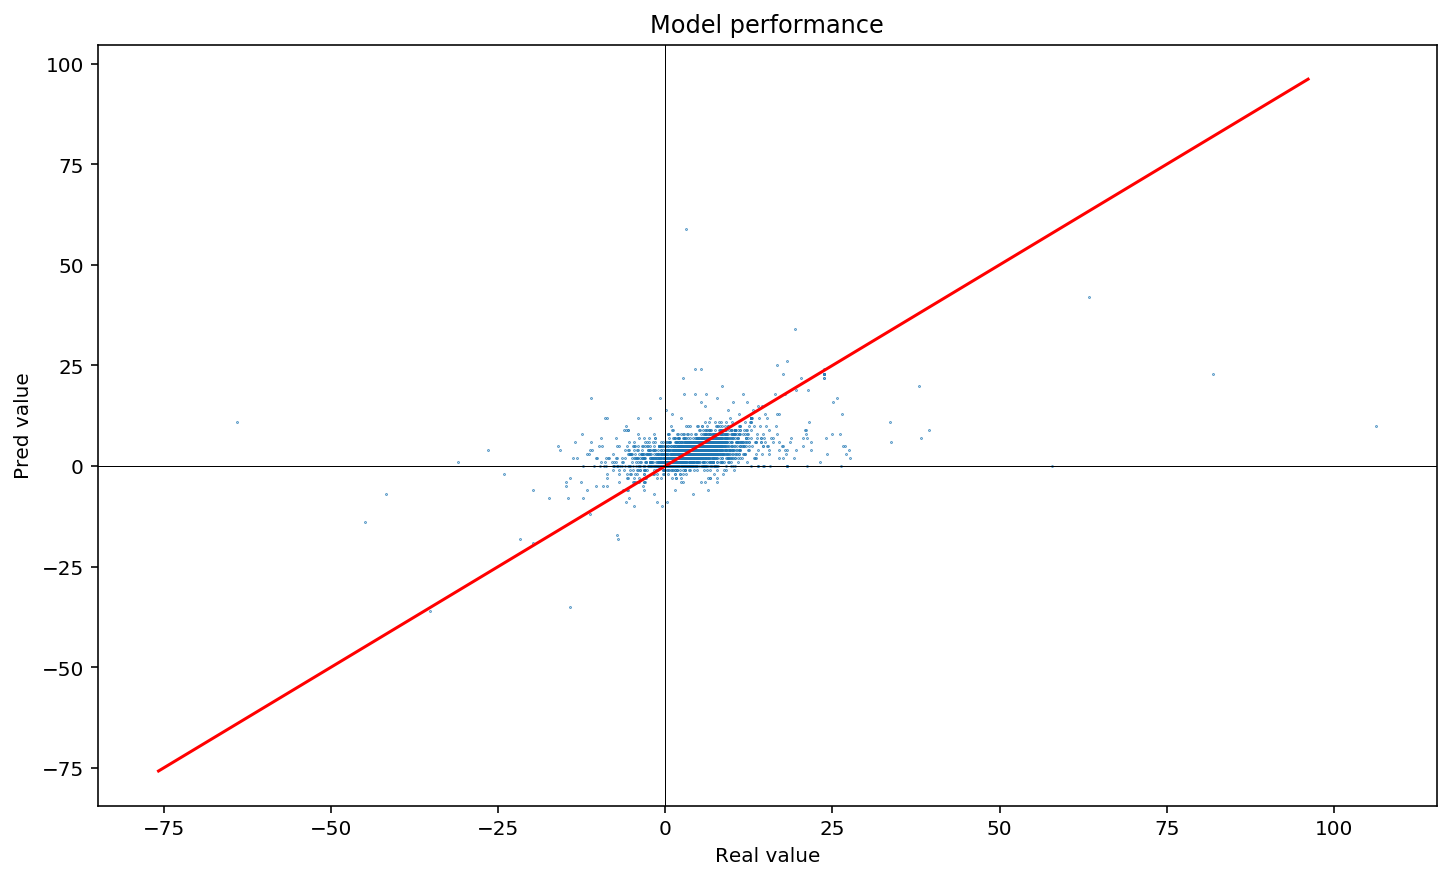

In [102]:
fig, ax = plt.subplots()
ax.set_title("Model performance")
ax.set_ylabel("Pred value")
ax.set_xlabel("Real value")
ax.scatter(results_df["y_real"], results_df["y_pred"], s=0.1)
ax.plot(plot_range, plot_range, c="red")
ax.axhline(linewidth=0.5, color='black')
ax.axvline(linewidth=0.5, color='black')
plt.show();

Another way of seeing this distribution is using histograms.

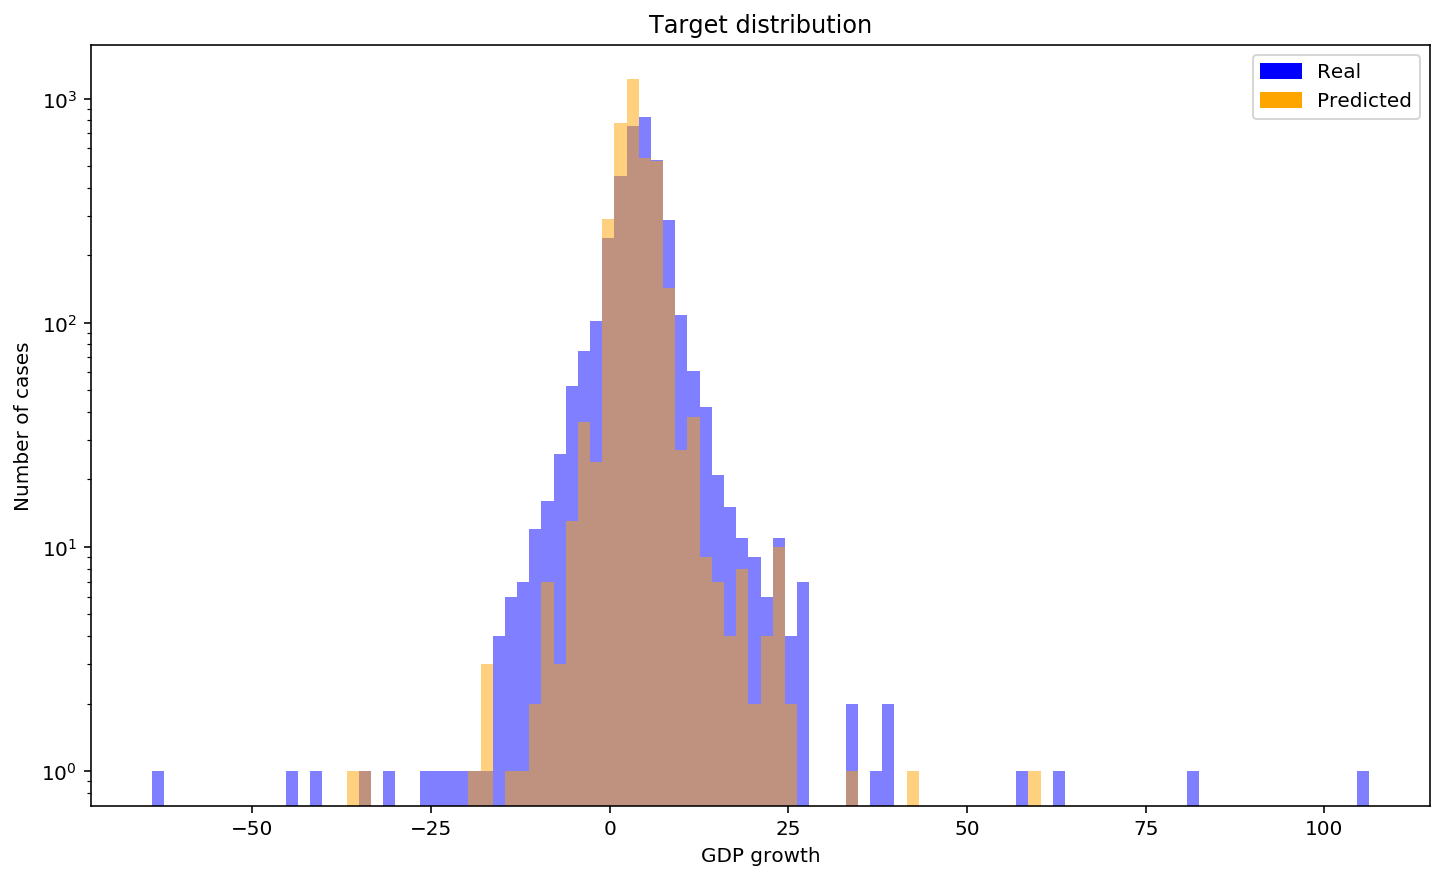

In [104]:
fig, ax = plt.subplots()
plot_range = [results_df["y_real"].min(), results_df["y_real"].max()]
ax.set_title("Target distribution")
ax.set_ylabel("Number of cases")
ax.set_xlabel("GDP growth")
ax.set_yscale("log")
ax.hist(results_df["y_real"], bins=100, color="blue", alpha=0.5, range=plot_range)
ax.hist(results_df["y_pred"], bins=100, color="orange", alpha=0.5, range=plot_range)
real = mpatches.Patch(color='blue', label='Real')
pred = mpatches.Patch(color='orange', label='Predicted')
plt.legend(handles=[real,pred])
plt.show();

Here we can see that the distribution from both, the predicted and real values, follow the same trend. The distributions of errors is plotted below.

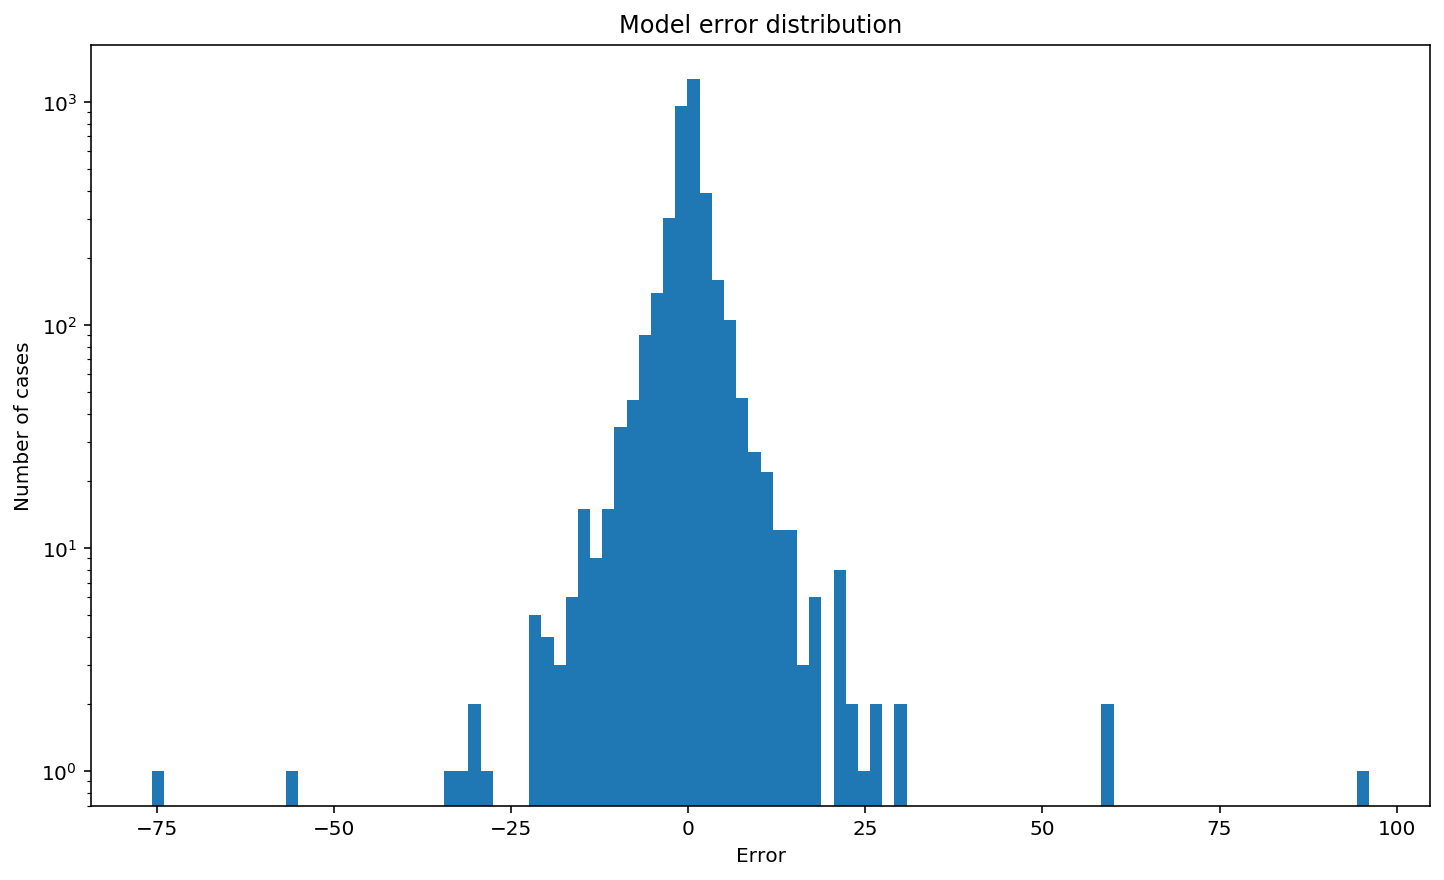

In [71]:
err = y_test.values-y_
fig, ax = plt.subplots()
plot_range = [err.min(), err.max()]
ax.set_title("Model error distribution")
ax.set_ylabel("Number of cases")
ax.set_xlabel("Error")
ax.set_yscale("log")
ax.hist(err, bins=100)
plt.show();

### 4. Conclusions

This model works well for predicting when the growth rate between years is not big enough. For countries with a bigger GDP growth the model gives an estimation with some error. However, the model also gives a bad performance in the rest of the cases.

We think that one of the reasons this happened is because of the huge number (2/3) of `NaN` variables in the `dataframe`, which difficulted the task. One solution would be to try again with a better `dataframe`.

We have tried with a few types of regressors and we have kept the least worse. Even though, the correlation that the final model gives us is $R^2=0.233$ which shows us that is not a very good model.